In [2]:
############
# Imports #
############

import json
import os

import wandb
import pandas as pd
import rasterio
import torch
import torchvision.utils as vutils
import numpy as np

from torch.utils.data import DataLoader
from PIL import Image

from model.cnn_classifier import model_4D
from model.pseudomask import Pseudomasks
from utils.data_modules import ImageDataset, TestSet, filter_dataset

##################
## load configs ##
##################

# use this path when using vs code debugger.
# config_path = os.path.join('/home/nadjaflechner/palsa_seg/current_models/pseudomask_generation_model', 'configs.json')

config_path = os.path.join(os.getcwd(), 'configs/pseudomasks_configs.json')
with open(config_path, 'r') as config_file:
    configs = json.load(config_file)

# assign paths
parent_dir = "/root/Permafrost-Segmentation/Current_Version/pseudomasks/Verified_GTs"
rgb_dir = os.path.join(parent_dir, 'rgb')
hs_dir = os.path.join(parent_dir, 'hs')
dem_dir = os.path.join(parent_dir, 'dem')
final_pseudomasks_dir = os.path.join(parent_dir, 'pseudomasks')
labels_file = os.path.join(parent_dir, 'new_palsa_labels_TINY.csv')

# load model configs dictionary
config_model = configs.get('model', {})
# assign model
artifact_path = config_model.get('artifact_path')
run_id = config_model.get('run_id')
finetune = config_model.get('finetuned')

# load data configs dictionary
config_data = configs.get('data', {})
# assign data configs
n_samples = config_data.get('n_samples')
batch_size = config_data.get('batch_size')
im_size = config_data.get('im_size')
min_palsa_positive_samples = config_data.get('min_palsa_positive_samples')
augment = config_data.get('augment')
normalize = config_data.get('normalize')
depth_layer = config_data.get('depth_layer')

# load pseudomasks configs dictionary
config_pseudomasks = configs.get('pseudomasks', {})
# assign pseudomasks configs
cam_threshold_factor = config_pseudomasks.get('cam_threshold_factor')
overlap_threshold = config_pseudomasks.get('overlap_threshold')
snic_seeds = config_pseudomasks.get('snic_seeds')
snic_compactness = config_pseudomasks.get('snic_compactness')


#########################
# configure dataloaders #
#########################

all_files = pd.read_csv(labels_file, index_col=0)

# choose depth data based on configs
depth_dir = hs_dir if depth_layer == "hs" else dem_dir
# Create the dataset and loaders for the entire dataset.
dataset = ImageDataset(depth_dir, rgb_dir, all_files, im_size, normalize)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

#############
# Init model: 

api = wandb.Api()
artifact = api.artifact(artifact_path, type='model')
artifact_dir = artifact.download()
state_dict = torch.load(f"{artifact_dir}/model.pth")
model = model_4D()
model.load_state_dict(state_dict)
model.eval()

#############################
# generate all pseudolabels #
#############################

pseudomask_generator = Pseudomasks(
    dataset, cam_threshold_factor, overlap_threshold,
    snic_seeds, snic_compactness, finetuned = finetune, std_from_mean=0
    )
pseudomask_generator.model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb:   1 of 1 files downloaded.  
/tmp/ipykernel_5109/2636737437.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHu

In [4]:
counter = 0
for im,binary_label,_,img_name in loader:

    # output paths:
    output_path_mask = os.path.join(final_pseudomasks_dir, 'masks', f"{img_name[0]}.png") 
    output_path_jpg = os.path.join(final_pseudomasks_dir, 'images', f"{img_name[0]}.jpg") 

    # Save RGB image
    vutils.save_image((im[:,:3,:,:]/255).cpu(), output_path_jpg, normalize = False)

    # Generate pseudomask 
    if binary_label == 0: 
        pseudomask = np.full((400, 400), False, dtype=bool)
    else:
        pseudomask = pseudomask_generator.generate_mask(im, None, save_plot=False)

    # Save pseudomask
    binary_pseudomask = np.squeeze(pseudomask.astype(np.uint8)) # convert bool to binary mask
    pseudomask_img = Image.fromarray(binary_pseudomask) # convert to pil img
    pseudomask_img.save(output_path_mask) # save as binary png

    counter+= 1

    if counter%100 ==0:
        print(f"{(counter/14567)*100} % of images produced")


1

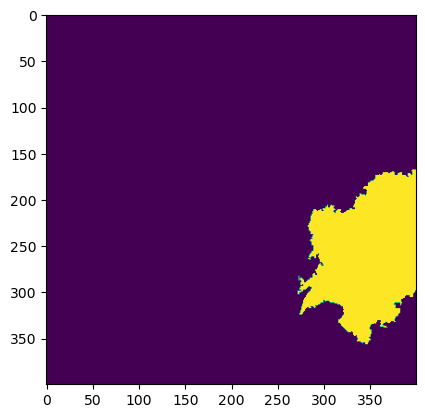

In [7]:
import matplotlib.pyplot as plt
immie = Image.open(output_path_mask)
plt.imshow(immie)
np.array(immie).max()